# **NYC Taxi Tipping Insights**

# **Overview**
New York City’s dense urban landscape relies on taxi services for millions of trips annually. The financial sustainability of this system depends heavily on tipping behaviors, which directly influence driver earnings and service quality. Understanding these patterns presents actionable opportunities to enhance operations across the taxi ecosystem.

This project aims to uncover the tipping trends to boost NYC taxi driver earnings and service strategies by comparing tips by time (rush hour, weekends, holidays), linking tip amounts to trip factors (distance, duration, time of day), and identifying most common tip percentage and passenger tipping rates.

# **Scope**
1. Do trips during non-rush hours receive higher tips than rush-hour trips?
2. Are tips higher during holidays?
3. Does trip distance or duration correlate with tip amount?
4. Do people tip more in the morning, afternoon, or late at night?
5. What is the most common trip percentage?
6. What share of passengers gave tips?
7. Do tipping habits differs on weekends vs. weekdays?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Understanding the data**

| **Column Name** | **Description** |
|-------------------------|---------------------------------------------------------------------------------|
| VendorID                | A code indicating the LPEP provider that provided the record. <br> 1 = Creative Mobile Technologies, LLC. <br> 2 = VeriFone Inc. |
| lpep_pickup_datetime    | The date and time when the meter was engaged.                                   |
| lpep_dropoff_datetime   | The date and time when the meter was disengaged.                                |
| Passenger_count         | The number of passengers in the vehicle. This is a driver-entered value.        |
| Trip_distance           | The elapsed trip distance in miles was reported by the taximeter.               |
| PULocationID            | TLC Taxi Zone in which the taximeter was engaged.                               |
| DOLocationID            | TLC Taxi Zone in which the taximeter was disengaged.                            |
| RateCodeID              | The final rate code is in effect at the end of the trip. <br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br> 4 = Nassau or Westchester <br> 5 = Negotiated fare <br> 6 = Group ride |
| Store_and_fwd_flag      | This flag indicates whether the trip record was held in the vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. <br> Y = store and forward trip <br> N = not a store and forward trip |
| Payment_type            | A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br> 2 = Cash <br> 3 = No charge <br> 4 = Dispute <br> 5 = Unknown <br> 6 = Voided trip |
| Fare_amount             | The time-and-distance fare is calculated by the meter.                           |
| MTA_tax                 | $0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge   | $0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount              | This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount            | The total amount of all tolls paid in the trip.                                  |
| Total_amount            | The total amount charged to passengers. Does not include cash tips.              |
| Trip_type               | A code indicating whether the trip was a street hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. <br> 1 = Street-hail <br> 2 = Dispatch |

# **Cleaning the data**

In [2]:
pd.set_option('display.max_columns', None)
df= pd.read_csv('NYC TLC Trip Record.csv', low_memory=False)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


In [3]:
df_draft=df.copy()

**Drop irrelevant columns**

In [4]:
df_draft=df_draft.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'ehail_fee', 'trip_type'], axis=1)
df_draft.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
2,2023-01-01 00:35:12,2023-01-01 00:41:32,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,1.0,11.64,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00


**Handling missing values**

In [5]:
df_draft.isna().sum()

lpep_pickup_datetime        0
lpep_dropoff_datetime       0
PULocationID                0
DOLocationID                0
passenger_count          4324
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             4324
congestion_surcharge     4324
dtype: int64

In [6]:
df_draft.loc[df_draft['passenger_count'].isnull()].head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
63887,2023-01-01 00:28:00,2023-01-01 00:54:00,7,17,NaN,9.33,36.03,0.0,0.0,7.41,0.0,1.0,44.44,NaN,NaN
63888,2023-01-01 00:39:00,2023-01-01 00:52:00,37,37,NaN,2.67,14.55,0.0,0.0,3.11,0.0,1.0,18.66,NaN,NaN
63889,2023-01-01 00:58:00,2023-01-01 01:21:00,80,7,NaN,7.39,32.13,0.0,0.0,6.63,0.0,1.0,39.76,NaN,NaN
63890,2023-01-01 00:35:00,2023-01-01 00:55:00,169,42,NaN,4.04,17.85,0.0,0.0,0.00,0.0,1.0,18.85,NaN,NaN
63891,2023-01-01 00:45:00,2023-01-01 00:55:00,42,262,NaN,3.86,19.67,0.0,0.0,4.68,0.0,1.0,28.10,NaN,NaN


In [ ]:
df_draft = df_draft.dropna(subset=['passenger_count', 'payment_type', 'congestion_surcharge'])
df_draft

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
2,2023-01-01 00:35:12,2023-01-01 00:41:32,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,1.0,11.64,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1.0,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00
63883,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1.0,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00
63884,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1.0,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00
63885,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1.0,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75


In [ ]:
df_draft.isna().sum()

lpep_pickup_datetime     0
lpep_dropoff_datetime    0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
congestion_surcharge     0
dtype: int64

**Handling outliers**

In [ ]:
negative_fare_indices = df_draft[df_draft['fare_amount'] < 0].index.tolist()
canceled_trips = []

for index in negative_fare_indices:
    if index > 0:
        exact_index = index
        following_index = index + 1
        canceled_trips.append(df_draft.loc[exact_index])
        canceled_trips.append(df_draft.loc[following_index])


if canceled_trips:
    df_canceled_trips = pd.DataFrame(canceled_trips)
df_canceled_trips

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
662,2023-01-01 14:58:13,2023-01-01 14:58:39,75,74,2.0,0.17,-3.0,0.0,-0.5,0.0,0.0,-1.0,-4.5,3.0,0.0
663,2023-01-01 14:58:13,2023-01-01 14:58:39,75,74,2.0,0.17,3.0,0.0,0.5,0.0,0.0,1.0,4.5,3.0,0.0
898,2023-01-01 17:24:52,2023-01-01 17:25:12,193,193,1.0,0.00,-3.0,0.0,-0.5,0.0,0.0,-1.0,-4.5,4.0,0.0
899,2023-01-01 17:24:52,2023-01-01 17:25:12,193,193,1.0,0.00,3.0,0.0,0.5,0.0,0.0,1.0,4.5,4.0,0.0
1317,2023-01-02 02:05:08,2023-01-02 02:12:57,129,82,1.0,0.64,-8.6,-1.0,-0.5,0.0,0.0,-1.0,-11.1,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63656,2023-01-31 20:29:00,2023-01-31 20:29:14,74,74,1.0,0.00,2.5,0.5,0.5,0.0,0.0,0.3,3.8,3.0,0.0
63807,2023-01-31 22:44:16,2023-01-31 22:45:18,256,256,1.0,0.15,-3.7,-1.0,-0.5,0.0,0.0,-1.0,-6.2,3.0,0.0
63808,2023-01-31 22:44:16,2023-01-31 22:45:18,256,256,1.0,0.15,3.7,1.0,0.5,0.0,0.0,1.0,6.2,3.0,0.0
63868,2023-01-31 23:44:44,2023-01-31 23:45:15,264,264,1.0,0.00,-10.0,0.0,0.0,0.0,0.0,-1.0,-11.0,4.0,0.0


In [ ]:
df_draft = df_draft.drop(df_canceled_trips.index)
df_draft

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
2,2023-01-01 00:35:12,2023-01-01 00:41:32,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,1.0,11.64,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1.0,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00
63883,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1.0,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00
63884,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1.0,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00
63885,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1.0,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75


In [ ]:
df_outliers_1 = df_draft[df_draft['total_amount']<0]
df_outliers_1

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
30232,2023-01-16 03:39:38,2023-01-16 03:54:12,235,78,1.0,2.34,0.0,0.0,-0.5,0.0,0.0,-1.0,-1.50,2.0,0.00
30247,2023-01-16 04:11:30,2023-01-16 04:12:44,78,78,1.0,0.17,0.0,0.0,-0.5,0.0,0.0,-1.0,-1.50,2.0,0.00
36900,2023-01-19 13:49:39,2023-01-19 14:40:05,43,23,1.0,24.14,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.25,2.0,-2.75


In [ ]:
df_draft = df_draft.drop(df_outliers_1.index)

In [ ]:
df_draft['lpep_pickup_datetime'].sort_values(ascending=False)

25100    2023-02-01 03:10:05
63872    2023-01-31 23:58:23
63858    2023-01-31 23:56:16
63876    2023-01-31 23:53:41
63844    2023-01-31 23:45:10
                ...         
44       2023-01-01 00:04:25
24       2023-01-01 00:01:31
318      2022-12-09 14:55:42
298      2022-12-09 14:10:49
17874    2009-01-01 20:21:27
Name: lpep_pickup_datetime, Length: 63542, dtype: object

In [ ]:
df_draft = df_draft.drop(index=[318, 298, 17874]).reset_index(drop=True)

<Axes: xlabel='fare_amount', ylabel='Count'>

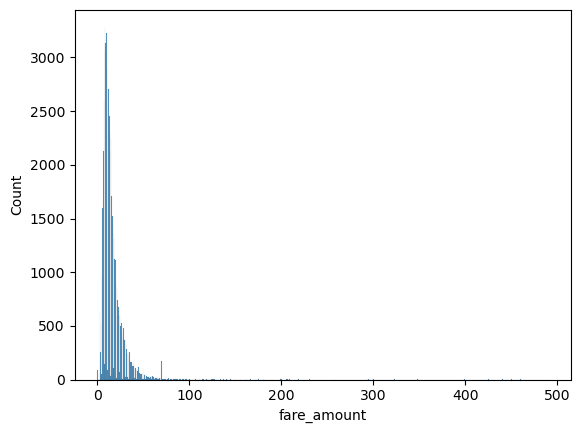

In [ ]:
sns.histplot(df_draft['fare_amount'])

<Axes: xlabel='total_amount', ylabel='Count'>

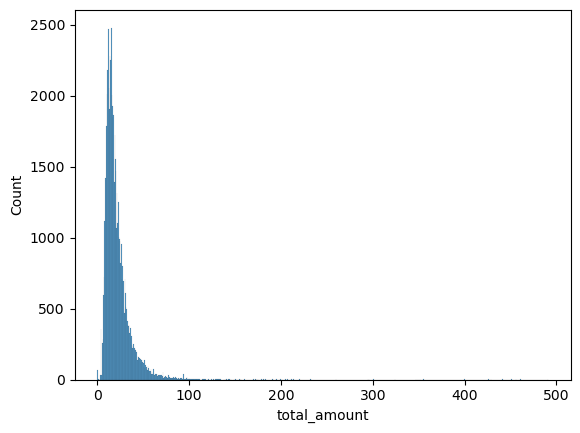

In [ ]:
sns.histplot(df_draft['total_amount'])

<Axes: xlabel='trip_distance', ylabel='Count'>

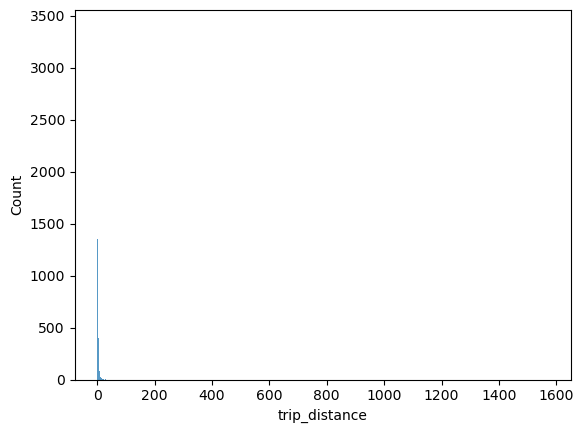

In [ ]:
sns.histplot(df_draft['trip_distance'])

In [ ]:
df_draft['fare_amount'].quantile(0.99)

63.9

In [ ]:
df_draft['fare_amount'].quantile(0.01)

3.0

In [ ]:
df_draft['fare_amount'].quantile(0.99)

63.9

In [ ]:
df_draft['fare_amount'].quantile(0.01)

3.0

In [ ]:
df_draft['trip_distance'].quantile(0.99)

13.606200000000026

In [ ]:
df_draft['trip_distance'].quantile(0.01)

0.0

In [ ]:
df_draft[((df_draft['fare_amount']<64) & (df_draft['total_amount']<64)) & (df_draft['trip_distance']<14)]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
2,2023-01-01 00:35:12,2023-01-01 00:41:32,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,1.0,11.64,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63534,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1.0,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00
63535,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1.0,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00
63536,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1.0,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00
63537,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1.0,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75


In [ ]:
df_draft[((df_draft['fare_amount']>3) & (df_draft['fare_amount']<64)) & ((df_draft['trip_distance']>0.0) & (df_draft['trip_distance']<14))]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00
5,2023-01-01 00:53:31,2023-01-01 01:11:04,41,262,1.0,2.78,17.7,1.0,0.5,0.00,0.0,1.0,22.95,2.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63534,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1.0,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00
63535,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1.0,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00
63536,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1.0,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00
63537,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1.0,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75


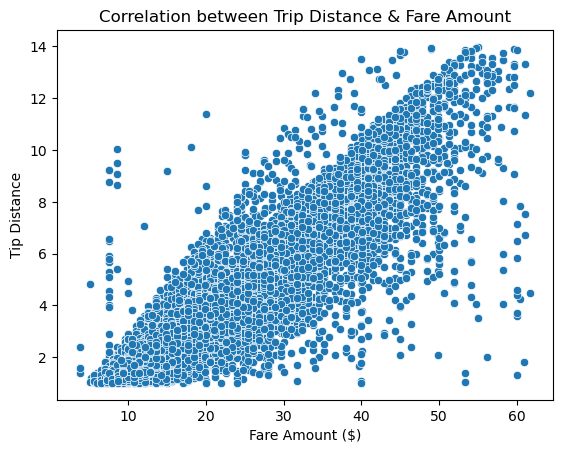

In [ ]:
sns.scatterplot(df_draft[((df_draft['fare_amount']>3) & (df_draft['fare_amount']<64)) &
                         ((df_draft['total_amount']>3) & (df_draft['total_amount']<64)) &
                         ((df_draft['trip_distance']>1) & (df_draft['trip_distance']<14))],
                         x='fare_amount', y='trip_distance')
plt.title('Correlation between Trip Distance & Fare Amount')
plt.ylabel('Tip Distance')
plt.xlabel('Fare Amount ($)')
plt.show()

In [ ]:
df_filtered = df_draft[((df_draft['fare_amount']>3) & (df_draft['fare_amount']<64)) & ((df_draft['total_amount']>3) & (df_draft['total_amount']<64)) & ((df_draft['trip_distance']>1) & (df_draft['trip_distance']<14))]
df_filtered

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00
5,2023-01-01 00:53:31,2023-01-01 01:11:04,41,262,1.0,2.78,17.7,1.0,0.5,0.00,0.0,1.0,22.95,2.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63534,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1.0,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00
63535,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1.0,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00
63536,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1.0,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00
63537,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1.0,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48720 entries, 0 to 63538
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lpep_pickup_datetime   48720 non-null  object 
 1   lpep_dropoff_datetime  48720 non-null  object 
 2   PULocationID           48720 non-null  int64  
 3   DOLocationID           48720 non-null  int64  
 4   passenger_count        48720 non-null  float64
 5   trip_distance          48720 non-null  float64
 6   fare_amount            48720 non-null  float64
 7   extra                  48720 non-null  float64
 8   mta_tax                48720 non-null  float64
 9   tip_amount             48720 non-null  float64
 10  tolls_amount           48720 non-null  float64
 11  improvement_surcharge  48720 non-null  float64
 12  total_amount           48720 non-null  float64
 13  payment_type           48720 non-null  float64
 14  congestion_surcharge   48720 non-null  float64
dtypes: floa

In [ ]:
df_filtered['passenger_count'] = df_filtered['passenger_count'].astype(int)

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/3097263370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['passenger_count'] = df_filtered['passenger_count'].astype(int)


# **Exploratory Data Analysis**

In [ ]:
df_filtered['tip_pct'] = df_filtered['tip_amount'] / df_filtered['fare_amount'] * 100

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/3266587831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['tip_pct'] = df_filtered['tip_amount'] / df_filtered['fare_amount'] * 100


In [ ]:
df_filtered['lpep_pickup_datetime'] = pd.to_datetime(df_filtered['lpep_pickup_datetime'])
df_filtered['lpep_dropoff_datetime'] = pd.to_datetime(df_filtered['lpep_dropoff_datetime'])

df_filtered['rush_hour'] = df_filtered['lpep_pickup_datetime'].dt.hour.isin([7, 8, 9, 16, 17, 18])

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/277894647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['lpep_pickup_datetime'] = pd.to_datetime(df_filtered['lpep_pickup_datetime'])
/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/277894647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['lpep_dropoff_datetime'] = pd.to_datetime(df_filtered['lpep_dropoff_datetime'])
/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/277894647.py:4

In [ ]:
df_filtered['pickup_date'] = df_filtered['lpep_pickup_datetime'].dt.date
df_filtered['pickup_time'] = df_filtered['lpep_pickup_datetime'].dt.time
df_filtered['dropoff_date'] = df_filtered['lpep_dropoff_datetime'].dt.date
df_filtered['dropoff_time'] = df_filtered['lpep_dropoff_datetime'].dt.time

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2398891734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pickup_date'] = df_filtered['lpep_pickup_datetime'].dt.date
/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2398891734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pickup_time'] = df_filtered['lpep_pickup_datetime'].dt.time
/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2398891734.py:3: SettingWithCopyWarning: 
A valu

In [ ]:
df_filtered['trip_duration_min'] = (df_filtered['lpep_dropoff_datetime'] - df_filtered['lpep_pickup_datetime']).dt.total_seconds() / 60

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/3335888692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['trip_duration_min'] = (df_filtered['lpep_dropoff_datetime'] - df_filtered['lpep_pickup_datetime']).dt.total_seconds() / 60


In [ ]:
month = df_filtered['lpep_pickup_datetime'].dt.month

conditions = [
    month.isin([12, 1, 2]),  # Winter
    month.isin([3, 4, 5]),   # Spring
    month.isin([6, 7, 8]),   # Summer
    month.isin([9, 10, 11])  # Fall
]

options = ['Winter', 'Spring', 'Summer', 'Fall']

df_filtered['season'] = np.select(conditions, options, default='Unknown')

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2739566684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['season'] = np.select(conditions, options, default='Unknown')


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_filtered['lpep_pickup_datetime'].min(), 
                        end=df_filtered['lpep_pickup_datetime'].max())

df_filtered['holiday'] = df_filtered['lpep_pickup_datetime'].dt.date.isin([d.date() for d in holidays])

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/4188882846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['holiday'] = df_filtered['lpep_pickup_datetime'].dt.date.isin([d.date() for d in holidays])


In [ ]:
df_filtered['weekend'] = df_filtered['lpep_pickup_datetime'].dt.weekday >= 5

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/3882829152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['weekend'] = df_filtered['lpep_pickup_datetime'].dt.weekday >= 5


In [ ]:
df_filtered.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID',
       'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'payment_type',
       'congestion_surcharge', 'tip_pct', 'rush_hour', 'pickup_date',
       'pickup_time', 'dropoff_date', 'dropoff_time', 'trip_duration_min',
       'season', 'holiday', 'weekend'],
      dtype='object')

In [ ]:
df_filtered

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,congestion_surcharge,tip_pct,rush_hour,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_duration_min,season,holiday,weekend
0,2023-01-01 00:26:10,2023-01-01 00:37:11,166,143,1,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,2.75,27.046980,False,2023-01-01,00:26:10,2023-01-01,00:37:11,11.016667,Winter,False,True
1,2023-01-01 00:51:03,2023-01-01 00:57:49,24,43,1,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,0.00,24.672897,False,2023-01-01,00:51:03,2023-01-01,00:57:49,6.766667,Winter,False,True
3,2023-01-01 00:13:14,2023-01-01 00:19:03,41,238,1,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,0.00,26.153846,False,2023-01-01,00:13:14,2023-01-01,00:19:03,5.816667,Winter,False,True
4,2023-01-01 00:33:04,2023-01-01 00:39:02,41,74,1,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,0.00,0.000000,False,2023-01-01,00:33:04,2023-01-01,00:39:02,5.966667,Winter,False,True
5,2023-01-01 00:53:31,2023-01-01 01:11:04,41,262,1,2.78,17.7,1.0,0.5,0.00,0.0,1.0,22.95,2.0,2.75,0.000000,False,2023-01-01,00:53:31,2023-01-01,01:11:04,17.550000,Winter,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63534,2023-01-31 23:09:22,2023-01-31 23:17:21,130,205,1,2.75,15.0,0.0,0.0,2.00,0.0,0.3,17.30,1.0,0.00,13.333333,False,2023-01-31,23:09:22,2023-01-31,23:17:21,7.983333,Winter,False,False
63535,2023-01-31 23:06:18,2023-01-31 23:17:03,65,181,1,2.44,13.5,1.0,0.5,3.20,0.0,1.0,19.20,1.0,0.00,23.703704,False,2023-01-31,23:06:18,2023-01-31,23:17:03,10.750000,Winter,False,False
63536,2023-01-31 23:17:03,2023-01-31 23:23:04,244,116,1,1.40,9.3,1.0,0.5,2.36,0.0,1.0,14.16,1.0,0.00,25.376344,False,2023-01-31,23:17:03,2023-01-31,23:23:04,6.016667,Winter,False,False
63537,2023-01-31 23:29:18,2023-01-31 23:38:50,74,238,1,2.47,13.5,1.0,0.5,3.75,0.0,1.0,22.50,1.0,2.75,27.777778,False,2023-01-31,23:29:18,2023-01-31,23:38:50,9.533333,Winter,False,False


# **1. Do trips during non-rush hours receive higher tips than rush-hour trips?**

In [ ]:
from scipy import stats

rush_tips = df_filtered[df_filtered['rush_hour']]['tip_amount'].dropna()      # True = Rush hour
nonrush_tips = df_filtered[~df_filtered['rush_hour']]['tip_amount'].dropna()  # False = Non-rush hour

t_stat, p_value = stats.ttest_ind(rush_tips, nonrush_tips)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference in tips (p < 0.05).")
else:
    print("No significant difference in tips (p >= 0.05).")

T-statistic: 7.38, P-value: 0.0000
Statistically significant difference in tips (p < 0.05).


In [ ]:
rush_tips_median = df_filtered[df_filtered['rush_hour']]['tip_amount'].median()      # True = Holiday
nonrush_tips_median = df_filtered[~df_filtered['rush_hour']]['tip_amount'].median()  # False = Non-holiday

print(f"Median tips amount during rush-hours: ${rush_tips_median:.2f} vs. non-rush hours: ${nonrush_tips_median:.2f}")

Median tips amount during rush-hours: $2.04 vs. non-rush hours: $2.00


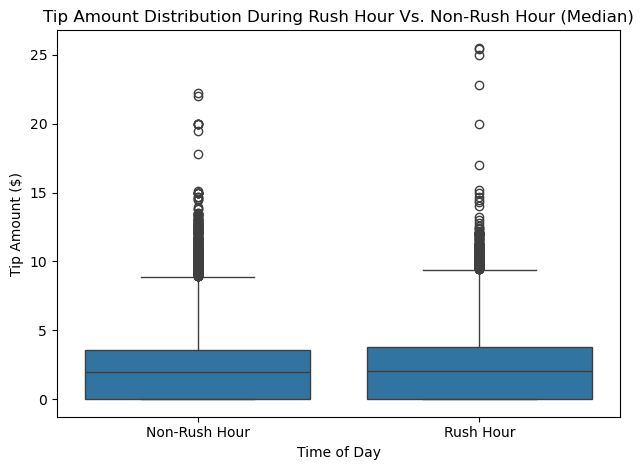

In [ ]:
sns.boxplot(data=df_filtered, x='rush_hour', y='tip_amount')
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])
plt.title('Tip Amount Distribution During Rush Hour Vs. Non-Rush Hour (Median)')
plt.ylabel('Tip Amount ($)')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.show()

# **2. Are tips higher during holidays?**

In [ ]:
holiday_tips = df_filtered[df_filtered['holiday']]['tip_amount'].dropna()      # True = Holiday
nonholiday_tips = df_filtered[~df_filtered['holiday']]['tip_amount'].dropna()  # False = Non-holiday

t_stat, p_value = stats.ttest_ind(holiday_tips, nonholiday_tips)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference in tips (p < 0.05).")
else:
    print("No significant difference in tips (p >= 0.05).")

T-statistic: -0.60, P-value: 0.5497
No significant difference in tips (p >= 0.05).


In [ ]:
holiday_tips_mean = df_filtered[df_filtered['holiday']]['tip_amount'].median()      # True = Holiday
nonholiday_tips_mean = df_filtered[~df_filtered['holiday']]['tip_amount'].median()  # False = Non-holiday

print(f"Tips on holidays: ${holiday_tips_mean:.2f} vs. non-holidays: ${nonholiday_tips_mean:.2f}")

Tips on holidays: $2.00 vs. non-holidays: $2.00


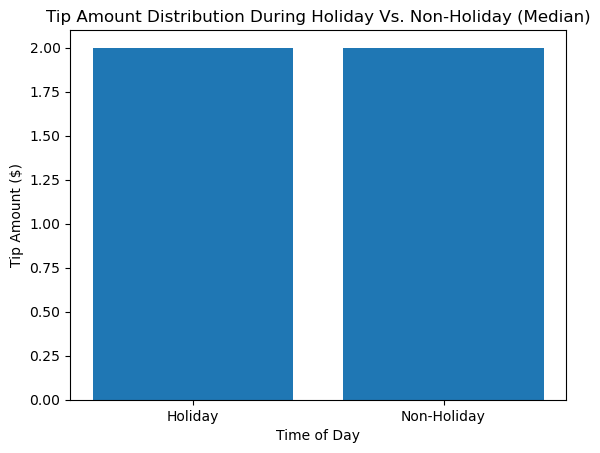

In [ ]:
labels = ['Holiday', 'Non-Holiday']
median_tips = [holiday_tips_mean, nonholiday_tips_mean]

plt.bar(labels, median_tips)
plt.title('Tip Amount Distribution During Holiday Vs. Non-Holiday (Median)')
plt.ylabel('Tip Amount ($)')
plt.xlabel('Time of Day')
plt.show()

# **3. Does trip distance or duration correlate with tip amount?**

In [ ]:
correlation = df_filtered[['tip_amount', 'trip_distance', 'trip_duration_min']].corr()
correlation

,tip_amount,trip_distance,trip_duration_min
tip_amount,1.000000,0.283393,0.008902
trip_distance,0.283393,1.000000,0.090201
trip_duration_min,0.008902,0.090201,1.000000


In [ ]:
print("- All correlations between tip amount and other variables are weak (close to 0).")
print("- This suggests that neither trip distance nor trip duration strongly influence how much passengers tip.")

- All correlations between tip amount and other variables are weak (close to 0).
- This suggests that neither trip distance nor trip duration strongly influence how much passengers tip.


In [ ]:
tip_dist_corr = correlation.loc['tip_amount', 'trip_distance']
tip_dur_corr = correlation.loc['tip_amount', 'trip_duration_min']

print(f"- Tip amount vs. Trip distance correlation: {tip_dist_corr:.3f} (very weak {'positive' if tip_dist_corr > 0 else 'negative'} relationship)")
print(f"- Tip amount vs. Trip duration correlation: {tip_dur_corr:.3f} (very weak {'positive' if tip_dur_corr > 0 else 'negative'} relationship)")

- Tip amount vs. Trip distance correlation: 0.283 (very weak positive relationship)
- Tip amount vs. Trip duration correlation: 0.009 (very weak positive relationship)


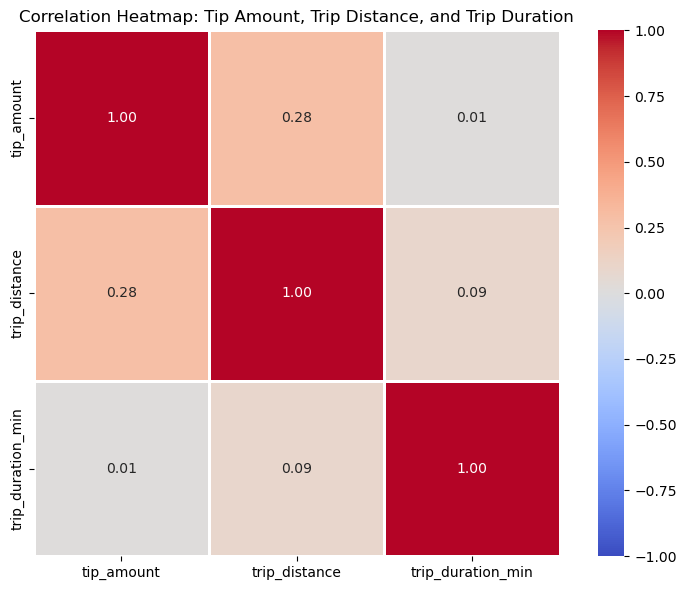

In [ ]:
correlation = df_filtered[['tip_amount', 'trip_distance', 'trip_duration_min']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, square=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Tip Amount, Trip Distance, and Trip Duration')
plt.tight_layout()
plt.show()

# **4. Do people tip more in the morning, afternoon, or late at night?**

- Late-night: 12am to 5:59am
- Morning: 6am to 11:59am
- Afternoon: 12pm to 5:59pm
- Evening: 6pm to 11:59pm

In [ ]:
df_filtered['time_of_day'] = df_filtered['lpep_pickup_datetime'].apply(
    lambda x: 'Late-night' if 0 <= x.hour < 6 else
              'Morning' if 6 <= x.hour < 12 else
              'Afternoon' if 12 <= x.hour < 18 else
              'Evening'
)

/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2444742366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_of_day'] = df_filtered['lpep_pickup_datetime'].apply(


In [ ]:
groups = [df_filtered[df_filtered['time_of_day'] == time]['tip_amount']  
         for time in ['Morning', 'Afternoon', 'Evening', 'Late-night']]  

stat, p_value = stats.kruskal(*groups)  
print(f"p-value: {p_value:.4f}")  
if p_value < 0.05:  
    print("Significant differences exist between groups.")  
else:  
    print("No significant differences.")  

p-value: 0.0000
Significant differences exist between groups.


In [ ]:
time_groups = df_filtered.groupby('time_of_day')['tip_amount'].median().sort_values(ascending=False)
highest_time = time_groups.idxmax()
highest_value = time_groups.max()
lowest_time = time_groups.idxmin()
lowest_value = time_groups.min()

print(f"- The highest tips occur during {highest_time} (${highest_value:.2f} - Median)")
print(f"- The lowest tips occur during {lowest_time} (${lowest_value:.2f} - Median)")

- The highest tips occur during Evening ($2.20 - Median)
- The lowest average tips occur during Late-night ($0.05 - Median)


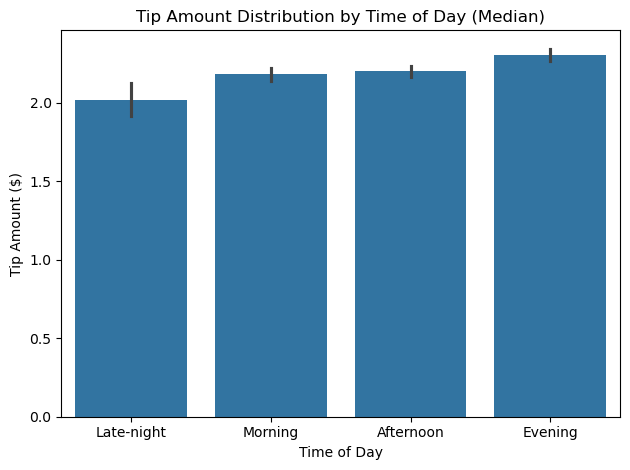

In [ ]:
sns.barplot(data=df_filtered, x='time_of_day', y='tip_amount', estimator='mean', order=['Late-night', 'Morning', 'Afternoon', 'Evening'])
plt.title('Tip Amount Distribution by Time of Day (Median)')
plt.ylabel('Tip Amount ($)')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.show()

# **5. What is the most common trip percentage?**

In [ ]:
df_filtered['tip_pct_rounded'] = df_filtered['tip_pct'].round().astype('Int64')

common_tip_pct = df_filtered[df_filtered['tip_pct_rounded'] > 0]['tip_pct_rounded'].mode()[0]
print(f"Most common rounded tip percentage: {common_tip_pct}%")

Most common rounded tip percentage: 23%


/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2698791308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['tip_pct_rounded'] = df_filtered['tip_pct'].round().astype('Int64')


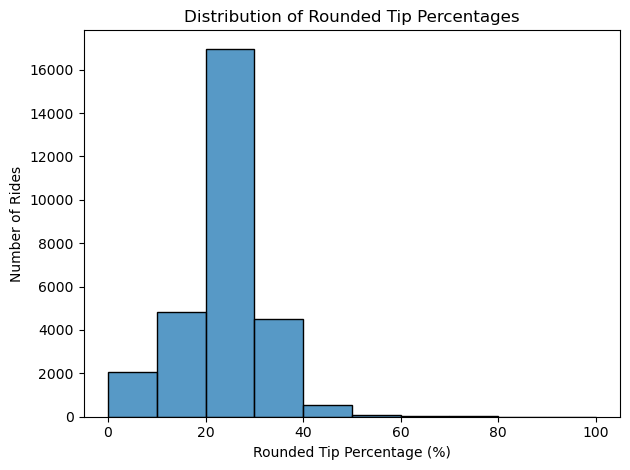

In [ ]:
max_tip = min(df_filtered[df_filtered['tip_pct_rounded'] > 0]['tip_pct_rounded'].max(), 100)  # Cap max tip to 100% if there are outliers
bin_edges = np.linspace(0, max_tip, num=11)

sns.histplot(df_filtered[df_filtered['tip_pct_rounded'] > 0]['tip_pct_rounded'], bins=bin_edges)
plt.title('Distribution of Rounded Tip Percentages')
plt.xlabel('Rounded Tip Percentage (%)')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

# **6. What share of passengers gave tips?**

In [ ]:
tipped_rides = df_filtered[df_filtered['tip_amount'] > 0].shape[0]
total_rides = df_filtered.shape[0]
tip_percentage = (tipped_rides / total_rides) * 100

print(f"{tip_percentage:.1f}% of passengers gave tips.")

60.1% of passengers gave tips.


/var/folders/k3/tr_j9hy50xqb3f4mb_0gngnc0000gn/T/ipykernel_5211/2122749994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Tipped'] = df_filtered['tip_amount'] > 0


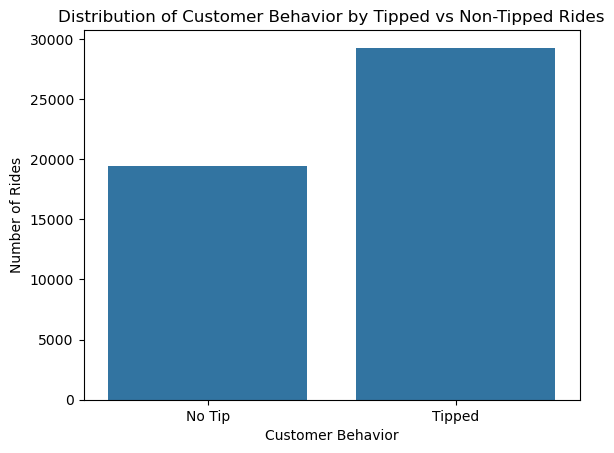

In [ ]:
df_filtered['Tipped'] = df_filtered['tip_amount'] > 0

sns.countplot(data=df_filtered, x='Tipped')
plt.xticks([0, 1], ['No Tip', 'Tipped'])
plt.title('Distribution of Customer Behavior by Tipped vs Non-Tipped Rides')
plt.ylabel('Number of Rides')
plt.xlabel('Customer Behavior')
plt.show()

# **7. Do tipping habits differs on weekends vs. weekdays?**

In [ ]:
weekday_tips = df_filtered[df_filtered['weekend'] == False]['tip_amount'].dropna()
weekend_tips = df_filtered[df_filtered['weekend'] == True]['tip_amount'].dropna()

t_stat, p_value = stats.ttest_ind(weekday_tips, weekend_tips, equal_var=False)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference in tips between weekdays and weekends (p < 0.05).")
else:
    print("No statistically significant difference in tips between weekdays and weekends (p >= 0.05).")

T-statistic: 0.63, P-value: 0.5310
No statistically significant difference in tips between weekdays and weekends (p >= 0.05).


In [ ]:
weekend_tips = df_filtered[df_filtered['weekend']]['tip_amount'].median()      # True = Weekend
weekday_tips = df_filtered[~df_filtered['weekend']]['tip_amount'].median()     # False = Weekday

print(f"Median tips on weekends: ${weekend_tips:.2f} vs. weekdays: ${weekday_tips:.2f}")

Median tips on weekends: $2.00 vs. weekdays: $2.00


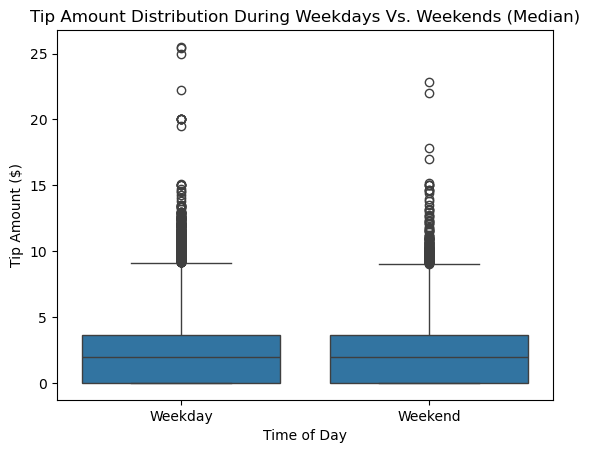

In [ ]:
sns.boxplot(data=df_filtered, x='weekend', y='tip_amount')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title('Tip Amount Distribution During Weekdays Vs. Weekends (Median)')
plt.ylabel('Tip Amount ($)')
plt.xlabel('Time of Day')
plt.show()

# **Exporting the data**

In [ ]:
df_filtered.to_excel('NYC TLC Trip Record_Cleaned.xlsx', index=False)